In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sqlite3
import taxis
from utils import *
from visualize import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from datetime import datetime
from sklearn.cluster import *
from sklearn.svm import *

DBNAME="../taxis.db"
LAT=1.380766
LON=103.891675
LAT1=1.303693
LON1=103.844952

In [2]:
holidays=['20170626']
def peak(h):
    return 1 if ((h>6 and h <9) or (h > 18)) else 0

def weekday(d):
    dt=datetime.strptime(d,"%Y%m%d")
    return 1 if datetime.isoweekday(dt)<6 else 0

df=taxis.get_df_all_taxi_data(DBNAME,LAT1,LON1)
df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
df['PeakHour']=df.apply(lambda r: peak(r['Hour']),axis=1)
df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)


In [3]:
df.tail()

,Point,Date,Time,X,Y,TaxiCount,Hour,Minute,PeakHour,Weekday,Holiday
4119,4119,20170708,2330,20,5,20,23,30,1,0,0
4120,4120,20170708,2335,20,5,18,23,35,1,0,0
4121,4121,20170708,2340,20,5,25,23,40,1,0,0
4122,4122,20170708,2345,20,5,28,23,45,1,0,0
4123,4123,20170708,2350,20,5,23,23,50,1,0,0


In [31]:
h=df.quantile(q=0.7)['TaxiCount']
l=df.quantile(q=0.3)['TaxiCount']

In [37]:
df_sub=df.query('(TaxiCount>@l and TaxiCount<@h) and (Hour>0 and Hour<12)')[['Point','Hour','Minute','PeakHour','Weekday','Holiday','TaxiCount']]
df_sub.head()

,Point,Hour,Minute,PeakHour,Weekday,Holiday,TaxiCount
0,0,9,0,0,0,0,58
2,2,9,10,0,0,0,64
30,30,11,30,0,0,0,63
32,32,11,40,0,0,0,62
33,33,11,45,0,0,0,62


In [33]:
df_sub.corr()

,Point,Hour,Minute,PeakHour,Weekday,Holiday,TaxiCount
Point,1.000000,-0.203760,-0.035061,0.213646,0.274652,-0.411490,-0.197822
Hour,-0.203760,1.000000,-0.094448,-0.847253,-0.326045,0.262861,0.321829
Minute,-0.035061,-0.094448,1.000000,0.118035,-0.045551,0.011838,-0.048172
PeakHour,0.213646,-0.847253,0.118035,1.000000,0.218761,-0.266833,-0.471093
Weekday,0.274652,-0.326045,-0.045551,0.218761,1.000000,0.229017,-0.200428
Holiday,-0.411490,0.262861,0.011838,-0.266833,0.229017,1.000000,0.103662
TaxiCount,-0.197822,0.321829,-0.048172,-0.471093,-0.200428,0.103662,1.000000


In [38]:
f=df['Point'].count()
c=int(f*0.8)
d=f-c
print c
print d
training=df_sub.head(c)
testing=df_sub.tail(d)

3299
825


In [39]:
X=training.drop(['Point','TaxiCount'],axis=1).as_matrix()
y=np.array(training['TaxiCount'].tolist()).reshape(-1,1)

svc=SVC(kernel='rbf',C=10,probability=True).fit(X,y)
print svc

svc.score(X,y)
#plt.plot(y,color='g')
#plt.plot(svc.predict(X),color='r')
#plt.show()


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


0.48880597014925375

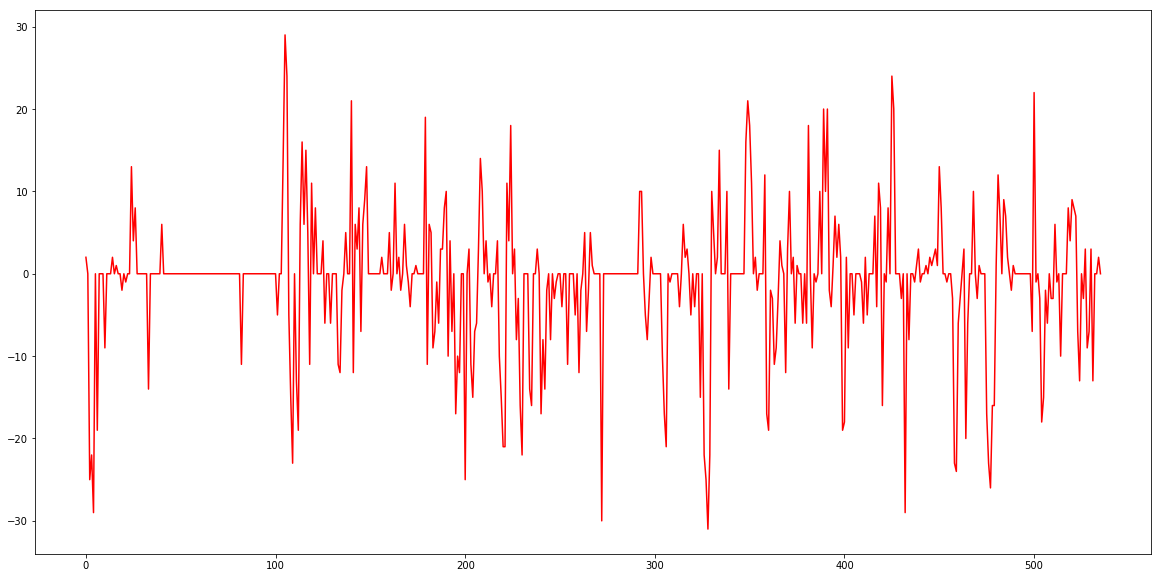

In [40]:
Xt=testing.drop(['Point','TaxiCount'],axis=1).as_matrix()
yt=np.array(testing['TaxiCount'].tolist()).reshape(-1,1)
P=svc.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

#plt.plot(yt,color='g')
#plt.plot(P,color='b')
plt.plot(e,color='r')
plt.show()